# Import Libraries

In [1]:
# importing the libraries
import pandas as pd
import numpy as np
import os
import cv2
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

# for reading and displaying images
from skimage import io
from skimage.io import imread
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# PyTorch libraries and modules
import torch
from torch import nn
from torch.autograd import Variable
from torch.nn import Linear, ReLU, Tanh, Hardtanh, LeakyReLU, ELU, Sigmoid, CrossEntropyLoss, Sequential, Conv2d, ConvTranspose2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD, RMSprop
import torch.nn.functional as f
import torchvision.transforms as transforms

In [2]:
data = os.uname()
global device
if data[1] == 'lambda-dual':
    device = 'cuda:1'
    print('The model will be trained on {}'.format(device))
    data_dir = '/home/arya1080/engrprojects/WilsonGroup/TuCo/data/20210920 modify SVD_mods_Arya/620nm/'
    save_dir = '/home/arya1080/engrprojects/WilsonGroup/MRA_grant/work_in_progress_arya/spectral_autoencoder_data/'
    print('Data will be loaded from "{}"'.format(data_dir))
    print('Data will be saved to "{}"'.format(save_dir))
elif data[1] == 'linuxg3' or data[1] == 'linuxg4':
    device = 'cuda:0'
    data_dir = '/top/projects/WilsonGroup/TuCo/data/20210920 modify SVD_mods_Arya/620nm/'
    save_dir = '/top/projects/WilsonGroup/MRA_grant/work_in_progress_arya/spectral_autoencoder_data/'
    print('The model will be trained on {}'.format(device))
    print('Data will be saved to "{}"'.format(save_dir))
    

The model will be trained on cuda:1
Data will be loaded from "/home/arya1080/engrprojects/WilsonGroup/TuCo/data/20210920 modify SVD_mods_Arya/620nm/"
Data will be saved to "/home/arya1080/engrprojects/WilsonGroup/MRA_grant/work_in_progress_arya/spectral_autoencoder_data/"


# Load dataset

In [3]:
# loading dataset
filenames = os.listdir(data_dir)
img_stack = []
for files in filenames:
    img = io.imread(data_dir + files)
    img_stack.append(img)

# convert images to numpy arrays
img_stack = np.asarray(img_stack)
img_stack = img_stack.astype('float32')

# get image height and width metrics
_, nx, ny, nch = img_stack.shape
print('Input dataset specs:')
print('img width = {}, img height = {}, img channels = {}'.format(nx, ny, nch))

# process the input image stack
img_stack = torch.tensor(img_stack)
img_stack = img_stack.to(device)


Input dataset specs:
img width = 681, img height = 406, img channels = 9


In [4]:
def load_batch_data(img_stack, batch_size, patch_size):
    batch_stack = []
    for i in range(0,batch_size):
        transform = transforms.RandomCrop((patch_size, patch_size))
        img_stack_p = torch.permute(img_stack, (0, 3, 1, 2))
        image_crop = transform(img_stack_p[random.randint(0,22),:,:,:])
#         print(image_crop.size)
        image_crop = torch.permute(image_crop, (1,2,0))
        batch_stack.append(image_crop)
    return batch_stack

# Define functions

In [30]:
class ResnetBlock(Module):
    def __init__(self, channels, kernel_size, stride, padding):
        super(ResnetBlock, self).__init__()
        self.conv = Sequential(
                        Conv2d(in_channels=channels, 
                          out_channels=channels,
                          kernel_size=kernel_size,
                          stride=stride,
                          padding=padding, bias=False) )
        
    def forward(self, x):
        intermediate = self.conv(x)
        out = x + intermediate
        return out
        

class ScalableSat(Module):
    def __init__(self):
        super(ScalableSat, self).__init__()
 
        self.a = nn.parameter.Parameter(torch.Tensor([1.0,1.0,0.0]))
        self.tanh = Hardtanh()
        
    def forward(self,x):
        return self.a[1]*self.tanh(self.a[0]*x)+self.a[2]
    
class LeakyHardsigmoid(Module):
    def __init__(self, negative_slope=0.1):
        super(LeakyHardsigmoid,self).__init__()
        self.ns = negative_slope
        
    def forward(self,x):
        return f.leaky_relu(-f.leaky_relu(-(x-3)/6,negative_slope=self.ns)+1,negative_slope=self.ns)

class OffsetHardsigmoid(Module):
    def __init__(self):
        super(OffsetHardsigmoid,self).__init__()
        
        
    def forward(self,x):
        return f.hardsigmoid(x-3)

class OffsetLeakyHardsigmoid(Module):
    def __init__(self):
        super(OffsetLeakyHardsigmoid,self).__init__()
        
        
    def forward(self,x):
        return f.rrelu(-f.rrelu(-(x-1),lower=0)+1,lower=0)
    
class AbsActivation(Module):
    def __init__(self):
        super(AbsActivation,self).__init__()
        
    def forward(self,x):
        return torch.abs(x)

class NormalizeEndmembers(Module):
    def forward(self,X):
        return X / X.norm(dim=0)
            
class Net(Module):   
    def __init__(self):
        super(Net, self).__init__()
        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            Conv2d(nch, 48, kernel_size=3, stride=1, padding=1, bias=False),
            LeakyReLU(),
#             BatchNorm2d(48),
#             Dropout(0.2),
            Conv2d(48, nch_bottleneck, kernel_size=1, stride=1, padding=0, bias=False),
            LeakyReLU(),
#             BatchNorm2d(nch_bottleneck),
#             Dropout(0.2),
            
            # implementing the softmax
            Softmax(dim=1)
        )
        
        self.cnn_spectral_layers = Sequential(
            # Defining a 2D convolution layer
            Conv2d(nch_bottleneck, nch, kernel_size=1, stride=1, padding=0, bias=False),  
        )
       
        
    def getSOEMlayer(self):
        return self.cnn_spectral_layers[0]
    
    # Defining the forward pass    
    def forward(self, x):
        z = self.cnn_layers(x)
        y = self.cnn_spectral_layers(z)
        return y
    
    def forward_enc(self, x):
        z = self.cnn_layers(x)
        return z
    
    def forward_dec(self, z):
        y = self.cnn_spectral_layers(z)
        return y
    
def initialize_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.xavier_uniform_(m.weight.data)

# define latent space visualization function
def visualize_z(ind):
    data = img_stack[ind,:,:,:]
    data = data[None,:]
    data = data.to(device)
    out = model.forward_enc(torch.permute(data, (0, 3, 1, 2)))
    out = out[0,:,:,:]
    out = torch.permute(out, (1,2,0))
    img = out.detach().cpu().numpy()
    plt.figure(figsize=(10,10))
    plt.imshow(1.2*img[:,:,0:3])
    plt.show()
    return img

# define latent space visualization function
def generate_z_image(ind, indices):
    data = img_stack[ind,:,:,:]
    data = data[None,:]
    data = data.to(device)
    out = model.forward_enc(torch.permute(data, (0, 3, 1, 2)))
    out = out[0,indices[0:3],:,:]
    out = torch.permute(out, (1,2,0))
    img = out.detach().cpu().numpy()
    return 1.*img

def visualSummary(L1_loss, indices):
    plt.figure(figsize=(12,6))
    plt.subplot(2,3,(1,4))
    img1 = generate_z_image(0, indices)
    plt.imshow(img1)
    plt.subplot(2,3,(2,5))
    img2 = generate_z_image(1, indices)
    plt.imshow(img2)
    plt.subplot(2,3,3)
    w = model.getSOEMlayer().weight
    w = w.detach().cpu().numpy().squeeze()
    tau=np.array([-2,0,0.2,0.4,1,2,4,6,14])
    print(w.shape)
    plt.plot(tau,w[:,indices[0]],'r')
    plt.plot(tau,w[:,indices[1]],'g')
    plt.plot(tau,w[:,indices[2]],'b')
    plt.title('recovered endmembers')
    plt.xlabel('probe delay, ps')
    plt.subplot(2,3,6)
    plt.plot(L1_loss)
    plt.title('Train Loss')
    plt.xlabel('Epochs')
    plt.ylabel('L1 Loss')
    plt.tight_layout()
    plt.show()
    return img1, img2
    
# Custom Loss Functions
def meansq(x):
    return torch.mean((x-torch.mean(x))**2)

def corr(x,y):
    return torch.sum(x*y) / (torch.sqrt(torch.sum(x**2))*torch.sqrt(torch.sum(y**2)))

# model training routine definition
def train_model(model, n_epochs, img_stack, lr):
    
    # define loss function
    criterion = nn.L1Loss()
    
    # define optimizer
    optimizer = torch.optim.RMSprop(model.parameters(), lr)
    
    # apply initialization
    model.apply(initialize_weights)
    
    # initialize model weights and send to train device
    model.to(device) # load the model in the training device
    
    # define variables
    total_loss = []
        
    # iterate over the epochs
    for epoch in tqdm(range(1, n_epochs+1)):
        
        # monitor training loss
        train_loss = 0.0
        
        # keep track of meansq value for each channel
        channelmsq = torch.zeros(nch_bottleneck).to(device)
        
        #Training        
        current_batch = load_batch_data(img_stack, 200, 200)
        
        for images in current_batch:
            images = images[None, :]
            image_x_p = torch.permute(images, (0, 3, 1, 2))
            image_x_p = image_x_p.to(device)
            optimizer.zero_grad()         
            z = model.forward_enc(image_x_p)
            outputs = model.forward_dec(z)
    
            # calculate the weighted spectral angular divergence (SAD) loss
#             in_product = torch.sum(torch.mul(image_x_p, outputs), dim = 1)
#             self_product = torch.sqrt(torch.sum(torch.mul(image_x_p, image_x_p), dim = 1)) * torch.sqrt(torch.sum(torch.mul(outputs, outputs), dim =1))            
#             cos_theta = torch.div(in_product, self_product)
#             theta = torch.acos(cos_theta)
#             mSAD = torch.mean(theta)
            
            # implement default cosine similarity loss
            cos = nn.CosineSimilarity(dim=1, eps=1e-8)
            cos_loss = torch.mean(torch.acos(cos(image_x_p, outputs)))
            
            # total loss
            loss = cos_loss
            loss.backward()
            optimizer.step()
            train_loss += loss.item()*image_x_p.size(0)
            
        train_loss = train_loss/len(img_stack)
        total_loss.append(train_loss)
        
        # rearrange channels so red has max variance, blue the least
        model.indices = channelmsq.argsort(descending=True)
        
        if epoch%(n_epochs/4) == 0:
            img1, img2 = visualSummary(total_loss, model.indices)
        
    return total_loss[-1], img1, img2



# Train model

Starting training of models on cuda:1


 25%|████████████▋                                      | 499/2000 [02:21<07:05,  3.53it/s]

(9, 3)


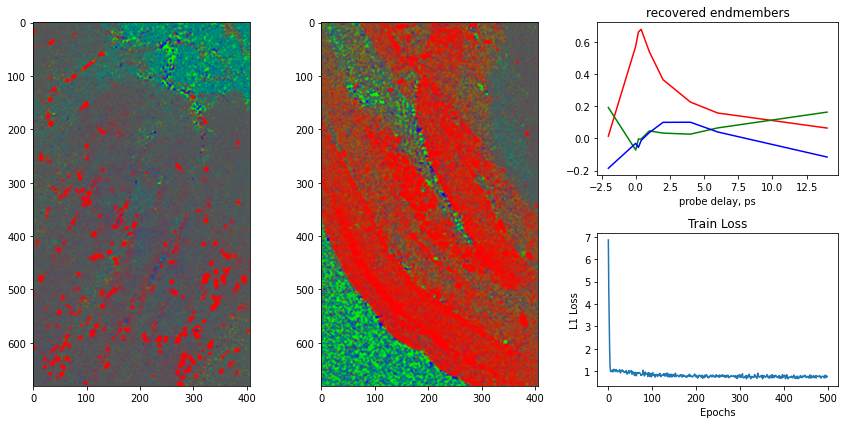

 50%|█████████████████████████▍                         | 999/2000 [04:44<04:50,  3.45it/s]

(9, 3)


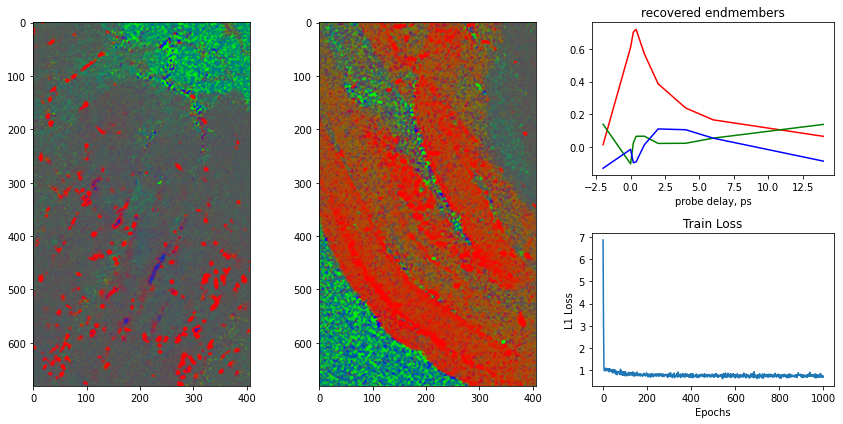

 75%|█████████████████████████████████████▍            | 1499/2000 [07:04<02:07,  3.92it/s]

(9, 3)


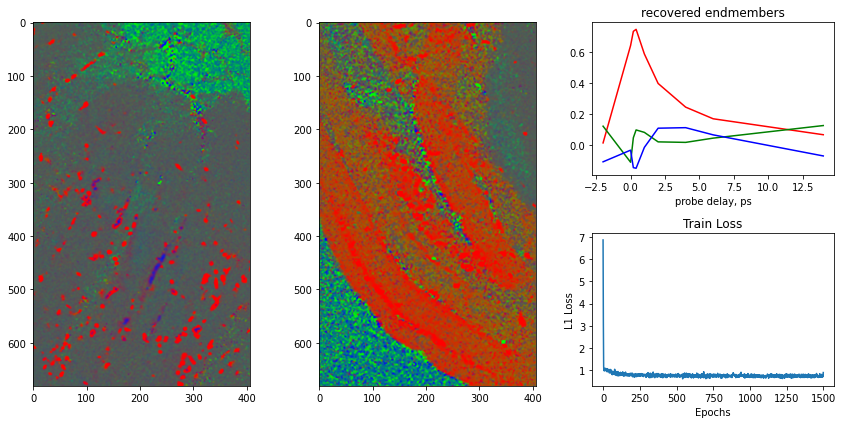

100%|█████████████████████████████████████████████████▉| 1999/2000 [09:27<00:00,  3.41it/s]

(9, 3)


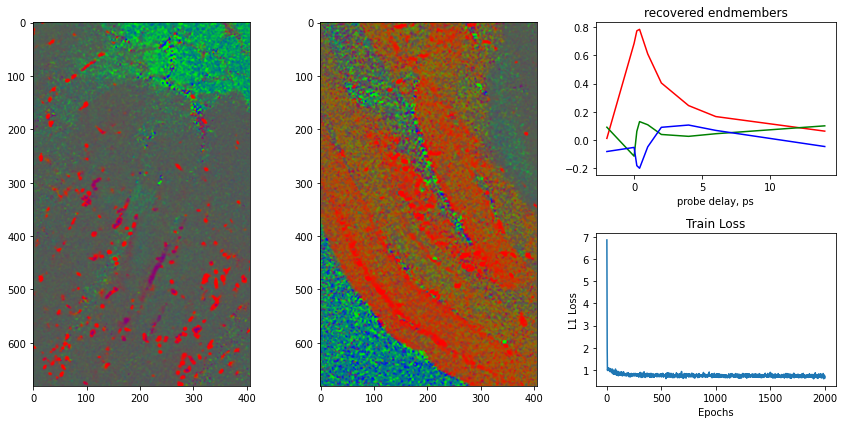

100%|██████████████████████████████████████████████████| 2000/2000 [09:28<00:00,  3.52it/s]

Runs done: 1/1


In [31]:
loss_arr = []

# number of times the experiment is repeated
n_runs = 1
n_epochs = 2000
learning_rate = 0.0003
nch_bottleneck = 3

print('Starting training of models on {}'.format(device))
n_count = 0
for i in range(1,n_runs+1):
    model = Net()
    loss, img1, img2 = train_model(model, n_epochs, img_stack, learning_rate)
    loss_arr.append((loss, img1, img2))
    n_count+=1
    print('Runs done: {}/{}'.format(n_count, n_runs))

In [18]:
images = img_stack[0,:,:,:]
images = images[None, :]
image_x_p = torch.permute(images, (0, 3, 1, 2))
image_x_p = image_x_p.to(device)
z = model.forward_enc(image_x_p)
outputs = model.forward_dec(z)

In [20]:
print(outputs.shape)

torch.Size([1, 9, 681, 406])


In [21]:
data = torch.mean(outputs, dim = [0,2,3])
print(data.shape)

torch.Size([9])


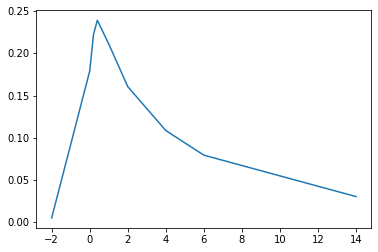

In [27]:
tau=np.array([-2,0,0.2,0.4,1,2,4,6,14])
plt.plot(tau, data.detach().cpu().numpy())
plt.show()

In [32]:
loss_arr = sort_tuple(loss_arr)

In [ ]:
for x in loss_arr:
    print("Loss: ", x[0])
    plt.subplot(1,2,1)
    plt.imshow(x[1])
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(x[2])
    plt.axis('off')
    plt.show()

# Analyze trained models

In [70]:
def basic_boxplot(dataList, expNameList, yRange, metric, dataNum, save=False):
    plt.figure(figsize=(18,6))
    plt.boxplot(dataList)
    plt.ylim(yRange)
    plt.grid()
    plt.xticks([i+1 for i in range(dataNum)], [expNameList[i] + ': ' + str(np.round(np.mean(dataList[i]),6)) for i in range(len(dataList))])
    if str(metric) == 'PSNR':
        plt.ylabel(str(metric) + ' dB')
    else:
        plt.ylabel(str(metric))
    plt.title(str(metric) + ' boxplots for different initialization techniques')
    if save:
        plt.savefig('Boxplot' + str(metric), dpi=100, bbox_inches='tight')
    plt.show()
    
def sort_tuple(data):
    data.sort(key = lambda x : x[0])
    return data

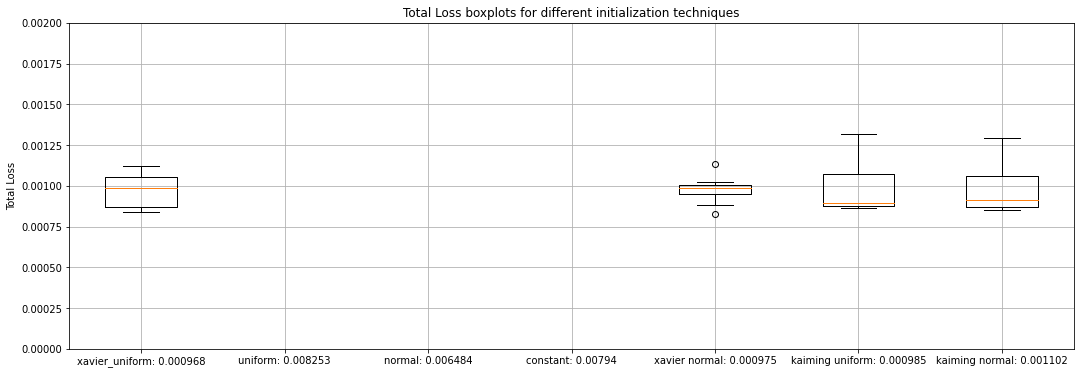

In [72]:
dataList = [loss_arr_xu, loss_arr_u, loss_arr_normal, loss_arr_constant, loss_arr_xn, loss_arr_ku, loss_arr_kn]
expNameList = ['xavier_uniform', 'uniform', "normal", 'constant', 'xavier normal', 'kaiming uniform', 'kaiming normal']
basic_boxplot(dataList, expNameList, [0, 0.002], 'Total Loss', 7, False)

# Experiment with new features